In [1]:
# Kuntal Ghosh
# May 2025

# This code implements graph neural networks (GNNs) with invariance/equivariance for molecular property prediction using the QM9 dataset

# Importing all necessary modules

import torch
import torch.nn as nn
from torch_geometric.datasets import QM9
from torch.utils.data import random_split, DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool
import torch.optim as optim
from torch_geometric.loader import DataLoader

import numpy as np
import matplotlib.pyplot as plt

# Data preparation and exploration: Downloading the QM9 dataset and exploring the features and how they vary.

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])
Dipole moment: mean = 7.298731080591678 std = 1.3576885006076191


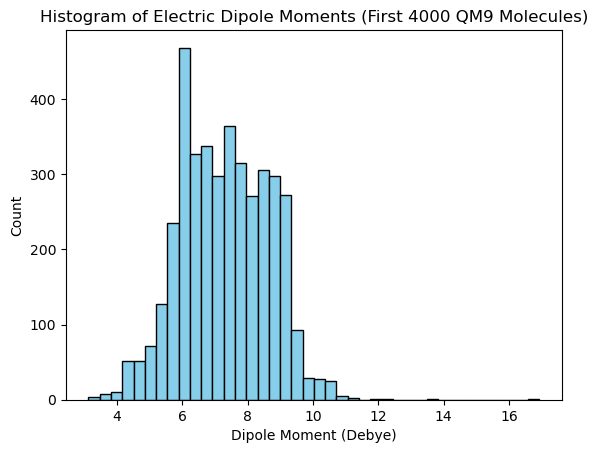

In [2]:
# Download and load the first 4000 structures
# Using the whole dataset is too computationally heavy
dataset = QM9(root='data/QM9')
subset = dataset[:4000]

# Explore features of the first molecule
print(subset[0])

# Extract the electric dipole moment (index 0 in data.y)
dipole_moments = [data.y[:,4].item() for data in subset]

# Display basic statistics
print("Dipole moment: mean =", np.mean(dipole_moments), "std =", np.std(dipole_moments))

# Plot histogram
plt.hist(dipole_moments, bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Electric Dipole Moments (First 4000 QM9 Molecules)')
plt.xlabel('Dipole Moment (Debye)')
plt.ylabel('Count')
plt.show()

# Normalization of the target feature (electric dipole moment) and make training, validation, and test sets. Preparing a DataLoader object for batching.

In [3]:
# Split dataset: 1500 train, 1500 validation, 1000 test
train_set, val_set, test_set = random_split(subset, [1500, 1500, 1000])

# Extract dipole moments from training set (assuming data.y is 2D: shape [1, 19])
train_targets = [data.y[:,0].item() for data in train_set]
mean = np.mean(train_targets)
std = np.std(train_targets)

# Normalize only the dipole moment (column 0) in data.y
def normalize(data):
    data.y[:,0] = (data.y[:,0] - mean) / std
    return data

train_set = [normalize(data) for data in train_set]
val_set = [normalize(data) for data in val_set]
test_set = [normalize(data) for data in test_set]

# Prepare DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# ‘2D’ GNN with permutation invariance/equivariance.

# Constructing MPNNLayer

In [4]:
# Define the MPNNLayer
class MPNNLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim):
        super().__init__(aggr='add')  # Use sum aggregation
        self.phi_e = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )
        self.phi_h = nn.Sequential(
            nn.Linear(2 * node_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, node_dim]
        # edge_index: [2, num_edges]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        # x_i, x_j: [num_edges, node_dim], edge_attr: [num_edges, edge_dim]
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=-1)
        return self.phi_e(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, node_dim], x: [num_nodes, node_dim]
        update_input = torch.cat([x, aggr_out], dim=-1)
        return self.phi_h(update_input)

# --- Demonstrate permutation equivariance ---

# Create a simple graph with 3 nodes and 2 edges
node_dim = 4
edge_dim = 2

x = torch.randn(3, node_dim)
edge_index = torch.tensor([[0, 1], [1, 2]])  # edges: 0->1, 1->2
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Make undirected: 0<->1, 1<->2
edge_attr = torch.randn(edge_index.size(1), edge_dim)

layer = MPNNLayer(node_dim, edge_dim)

# Forward pass on original graph
out_orig = layer(x, edge_index, edge_attr)

# Permute the nodes (e.g., swap node 0 and 2)
perm = torch.tensor([2, 1, 0])
x_perm = x[perm]
# Adjust edge_index to match the permutation
def permute_edge_index(edge_index, perm):
    inv = torch.argsort(perm)
    return inv[edge_index]

edge_index_perm = permute_edge_index(edge_index, perm)
out_perm = layer(x_perm, edge_index_perm, edge_attr)

# Undo the permutation on the output to compare
out_perm_unperm = out_perm[torch.argsort(perm)]

# Check equivariance: outputs should be (almost) identical
print("Original output:\n", out_orig)
print("Permuted-then-unpermuted output:\n", out_perm_unperm)
print("Difference:\n", (out_orig - out_perm_unperm).abs().max())

Original output:
 tensor([[-0.6437,  0.4118, -0.1411,  0.2355],
        [-0.2563,  0.3346, -0.3509,  0.2116],
        [-0.7924,  0.4311, -0.0717,  0.2918]], grad_fn=<AddmmBackward0>)
Permuted-then-unpermuted output:
 tensor([[-0.6437,  0.4118, -0.1411,  0.2355],
        [-0.2563,  0.3346, -0.3509,  0.2116],
        [-0.7924,  0.4311, -0.0717,  0.2918]], grad_fn=<IndexBackward0>)
Difference:
 tensor(0., grad_fn=<MaxBackward1>)


# Constructing MPNNModel

In [5]:
class MPNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Linear(node_dim, node_dim)
        self.layers = nn.ModuleList([MPNNLayer(node_dim, edge_dim) for _ in range(num_layers)])
        self.readout = nn.Sequential(
            nn.Linear(node_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, 1)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, edge_index, edge_attr)
        x = global_add_pool(x, batch)
        return self.readout(x)

# --- Demonstrate permutation invariance ---

node_dim = 4
edge_dim = 2

# Graph 1: 3 nodes, 2 edges
x1 = torch.randn(3, node_dim)
edge_index1 = torch.tensor([[0, 1], [1, 2]], dtype=torch.long)
edge_attr1 = torch.randn(2, edge_dim)

# Graph 2: 4 nodes, 3 edges
x2 = torch.randn(4, node_dim)
edge_index2 = torch.tensor([[0, 1, 2], [1, 2, 3]], dtype=torch.long)
edge_attr2 = torch.randn(3, edge_dim)

# Combine into a batched graph
x = torch.cat([x1, x2], dim=0)
edge_index2_shifted = edge_index2 + x1.size(0)
edge_index = torch.cat([edge_index1, edge_index2_shifted], dim=1)  # Corrected: concatenate along dim=1
edge_attr = torch.cat([edge_attr1, edge_attr2], dim=0)
batch = torch.cat([torch.zeros(x1.size(0), dtype=torch.long), torch.ones(x2.size(0), dtype=torch.long)], dim=0)

model = MPNNModel(node_dim, edge_dim)

# Original prediction
out_orig = model(x, edge_index, edge_attr, batch)

# Permute nodes within each graph
perm1 = torch.tensor([2, 1, 0])
perm2 = torch.tensor([3, 2, 1, 0]) + x1.size(0)
perm = torch.cat([perm1, perm2])
x_perm = x[perm]
batch_perm = batch[perm]

# Update edge_index to reflect node permutation
def permute_edge_index(edge_index, perm):
    inv = torch.argsort(perm)
    return inv[edge_index]

edge_index_perm = permute_edge_index(edge_index, perm)
out_perm = model(x_perm, edge_index_perm, edge_attr, batch_perm)

print("Original output:\n", out_orig)
print("Permuted output:\n", out_perm)
print("Difference:\n", (out_orig - out_perm).abs().max())

Original output:
 tensor([[-0.1025],
        [-0.0663]], grad_fn=<AddmmBackward0>)
Permuted output:
 tensor([[-0.1025],
        [-0.0663]], grad_fn=<AddmmBackward0>)
Difference:
 tensor(0., grad_fn=<MaxBackward1>)


# Training the MPNNModel and plotting training, validation and test losses as functions of epoch

Epoch 01: train 1.1136 | val 1.0093 | test 0.9983
Epoch 02: train 0.9957 | val 1.0006 | test 0.9839
Epoch 03: train 0.9755 | val 0.9624 | test 0.9633
Epoch 04: train 0.8754 | val 0.8091 | test 0.8422
Epoch 05: train 0.8039 | val 0.7542 | test 0.7680
Epoch 06: train 0.7328 | val 0.7045 | test 0.7267
Epoch 07: train 0.6960 | val 0.6749 | test 0.6600
Epoch 08: train 0.6184 | val 0.5930 | test 0.5978
Epoch 09: train 0.5656 | val 0.5975 | test 0.5915
Epoch 10: train 0.5443 | val 0.5868 | test 0.5831
Epoch 11: train 0.5321 | val 0.5571 | test 0.5602
Epoch 12: train 0.5210 | val 0.5508 | test 0.5783
Epoch 13: train 0.5181 | val 0.5666 | test 0.5638
Epoch 14: train 0.5243 | val 0.5361 | test 0.5514
Epoch 15: train 0.5217 | val 0.5326 | test 0.5347
Epoch 16: train 0.5093 | val 0.5350 | test 0.5583
Epoch 17: train 0.5259 | val 0.5375 | test 0.5344
Epoch 18: train 0.5037 | val 0.5181 | test 0.5286
Epoch 19: train 0.4988 | val 0.5182 | test 0.5267
Epoch 20: train 0.4894 | val 0.5038 | test 0.5164


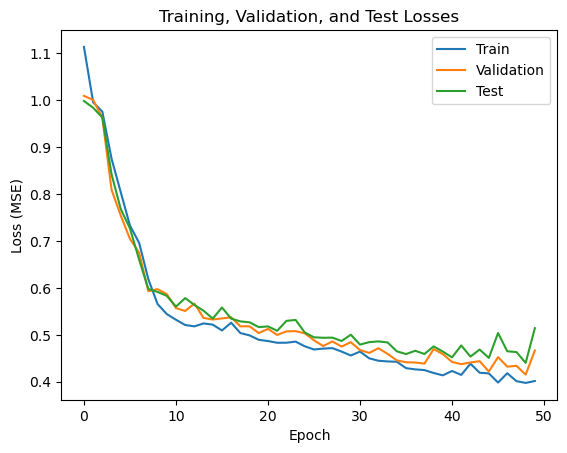

In [6]:
# Prepare DataLoader objects using PyG's DataLoader
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPNNModel(node_dim=11, edge_dim=4).to(device)  # Adjust node_dim and edge_dim as needed
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    losses = []
    with torch.set_grad_enabled(train):
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            y = batch.y[:,0]  # Target: normalized dipole moment
            loss = criterion(out.squeeze(), y)
            if train:
                loss.backward()
                optimizer.step()
            losses.append(loss.item())
    return sum(losses) / len(losses)

epochs = 50
train_losses, val_losses, test_losses = [], [], []

for epoch in range(epochs):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    test_loss = run_epoch(test_loader, train=False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1:02d}: train {train_loss:.4f} | val {val_loss:.4f} | test {test_loss:.4f}")

# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training, Validation, and Test Losses')
plt.legend()
plt.show()

# Constructing CoordMPNNModel, incorporating atom coordinates into the node features

In [7]:
class CoordMPNNLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim, coord_dim=3):
        super().__init__(aggr='add')
        # Now node features include both original features and coordinates
        self.phi_e = nn.Sequential(
            nn.Linear(2 * (node_dim + coord_dim) + edge_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )
        self.phi_h = nn.Sequential(
            nn.Linear(node_dim + coord_dim + node_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )

    def forward(self, x, pos, edge_index, edge_attr):
        # x: [num_nodes, node_dim]
        # pos: [num_nodes, 3]
        # edge_index: [2, num_edges]
        # edge_attr: [num_edges, edge_dim]
        # Concatenate coordinates to node features
        x_aug = torch.cat([x, pos], dim=-1)
        return self.propagate(edge_index, x=x_aug, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        # x_i, x_j: [num_edges, node_dim + coord_dim]
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=-1)
        return self.phi_e(msg_input)

    def update(self, aggr_out, x):
        # x: [num_nodes, node_dim + coord_dim]
        update_input = torch.cat([x, aggr_out], dim=-1)
        return self.phi_h(update_input)

class CoordMPNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, coord_dim=3, num_layers=3):
        super().__init__()
        self.embedding = nn.Linear(node_dim, node_dim)
        self.layers = nn.ModuleList([
            CoordMPNNLayer(node_dim, edge_dim, coord_dim) for _ in range(num_layers)
        ])
        self.readout = nn.Sequential(
            nn.Linear(node_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, 1)
        )

    def forward(self, x, pos, edge_index, edge_attr, batch):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, pos, edge_index, edge_attr)
        # Only use node features (not coordinates) for readout
        x = global_add_pool(x, batch)
        return self.readout(x)

# Training CoordMPNNModel and plotting losses

Epoch 01: train 0.9867 | val 0.9221 | test 0.9054
Epoch 02: train 0.8805 | val 0.9049 | test 0.8950
Epoch 03: train 0.8632 | val 0.8849 | test 0.8891
Epoch 04: train 0.8449 | val 0.8636 | test 0.8801
Epoch 05: train 0.8268 | val 0.8521 | test 0.8551
Epoch 06: train 0.8006 | val 0.8101 | test 0.8324
Epoch 07: train 0.7819 | val 0.8070 | test 0.8171
Epoch 08: train 0.7576 | val 0.7797 | test 0.7966
Epoch 09: train 0.7486 | val 0.7764 | test 0.8054
Epoch 10: train 0.7274 | val 0.7991 | test 0.7842
Epoch 11: train 0.7135 | val 0.7165 | test 0.7333
Epoch 12: train 0.6733 | val 0.6770 | test 0.7033
Epoch 13: train 0.6527 | val 0.6411 | test 0.6790
Epoch 14: train 0.6014 | val 0.6085 | test 0.6500
Epoch 15: train 0.5781 | val 0.5975 | test 0.6082
Epoch 16: train 0.5414 | val 0.5601 | test 0.5785
Epoch 17: train 0.5102 | val 0.5648 | test 0.5859
Epoch 18: train 0.5138 | val 0.5814 | test 0.6394
Epoch 19: train 0.4883 | val 0.5374 | test 0.5841
Epoch 20: train 0.4684 | val 0.5471 | test 0.5656


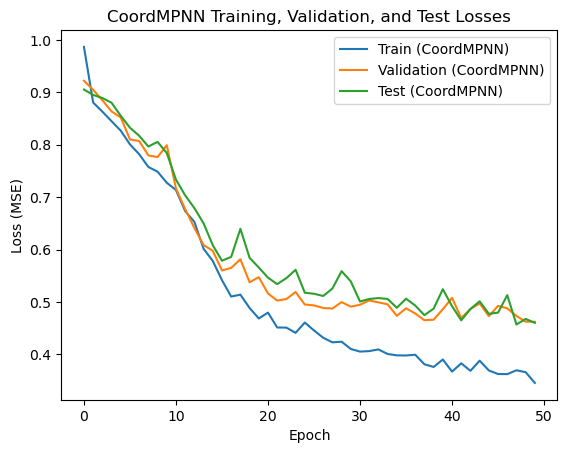

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CoordMPNNModel(node_dim=11, edge_dim=4).to(device)  # Adjust node_dim and edge_dim as needed
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    losses = []
    with torch.set_grad_enabled(train):
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.pos, batch.edge_index, batch.edge_attr, batch.batch)
            y = batch.y[:,0]  # Target: normalized dipole moment
            loss = criterion(out.squeeze(), y)
            if train:
                loss.backward()
                optimizer.step()
            losses.append(loss.item())
    return sum(losses) / len(losses)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

epochs = 50
train_losses_3d, val_losses_3d, test_losses_3d = [], [], []

for epoch in range(epochs):
    train_loss_3d = run_epoch(train_loader, train=True)
    val_loss_3d = run_epoch(val_loader, train=False)
    test_loss_3d = run_epoch(test_loader, train=False)
    train_losses_3d.append(train_loss_3d)
    val_losses_3d.append(val_loss_3d)
    test_losses_3d.append(test_loss_3d)
    print(f"Epoch {epoch+1:02d}: train {train_loss_3d:.4f} | val {val_loss_3d:.4f} | test {test_loss_3d:.4f}")

# Plot losses
plt.plot(train_losses_3d, label='Train (CoordMPNN)')
plt.plot(val_losses_3d, label='Validation (CoordMPNN)')
plt.plot(test_losses_3d, label='Test (CoordMPNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('CoordMPNN Training, Validation, and Test Losses')
plt.legend()
plt.show()

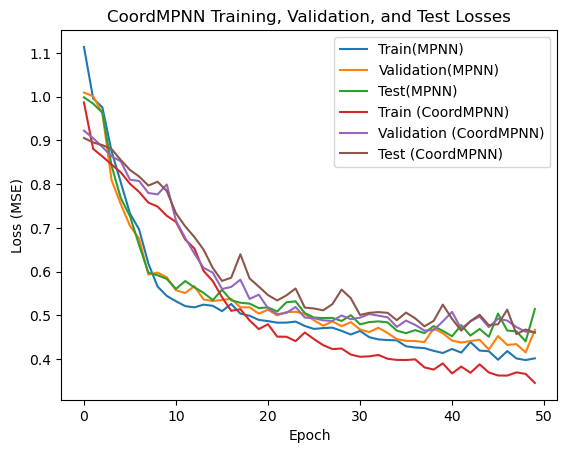

In [9]:
# To compare: Repeat the same training/plotting for MPNNModel (from Q2b) and overlay the curves for direct comparison.

# Plot losses
plt.plot(train_losses, label='Train(MPNN)')
plt.plot(val_losses, label='Validation(MPNN)')
plt.plot(test_losses, label='Test(MPNN)')
plt.plot(train_losses_3d, label='Train (CoordMPNN)')
plt.plot(val_losses_3d, label='Validation (CoordMPNN)')
plt.plot(test_losses_3d, label='Test (CoordMPNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('CoordMPNN Training, Validation, and Test Losses')
plt.legend()
plt.show()

A concrete comparsion is difficult, but overall it seems that the MSE losses are lower for CoordMPNN than MPNN.

# Testing rotational/translational invariance of CoordMPNNModel

In [10]:
def test_rot_trans_invariance(model, data, device='cpu'):
    """
    Tests rotational and translational invariance of CoordMPNNModel on a single molecule graph.
    Prints the original, translated, and rotated predictions and their differences.
    """
    model.eval()
    data = data.to(device)

    # Original prediction
    with torch.no_grad():
        pred_orig = model(data.x, data.pos, data.edge_index, data.edge_attr, data.batch)

    # Translation: shift all positions by a constant vector
    shift = torch.tensor([15.0, -2.0, 4.0], device=data.pos.device)
    pos_translated = data.pos + shift
    with torch.no_grad():
        pred_translated = model(data.x, pos_translated, data.edge_index, data.edge_attr, data.batch)

    # Rotation: apply a random rotation matrix (using QR decomposition for a valid rotation)
    def random_rotation_matrix():
        Q, _ = torch.linalg.qr(torch.randn(3, 3, device=data.pos.device))
        return Q

    R = random_rotation_matrix()
    pos_rotated = data.pos @ R.T
    with torch.no_grad():
        pred_rotated = model(data.x, pos_rotated, data.edge_index, data.edge_attr, data.batch)

    print("Original prediction:   ", pred_orig.cpu().numpy())
    print("Translated prediction: ", pred_translated.cpu().numpy())
    print("Rotated prediction:    ", pred_rotated.cpu().numpy())
    print("Translation difference:", (pred_orig - pred_translated).abs().max().item())
    print("Rotation difference:   ", (pred_orig - pred_rotated).abs().max().item())

data_example = test_set[1]  # Use any molecule from your test set
test_rot_trans_invariance(model, data_example, device)

Original prediction:    [[-0.43727952]]
Translated prediction:  [[5.8360624]]
Rotated prediction:     [[-1.0161208]]
Translation difference: 6.273342132568359
Rotation difference:    0.5788412690162659


# Constructing InvariantMPNNLayer and explicitly demonstrating invariance

$$
\begin{equation}
    h_i^{(l+1)} = \phi \left( h_i^{(l)}, \sum_{j \in \mathcal{N}(i)} \psi \left( h_i^{(l)}, h_j^{(l)}, d_{ij} \right) \right)
\end{equation}
$$

Here, $d_{ij} = \left\| \mathbf{r}_i - \mathbf{r}_j \right\|$ is the distance between nodes $i$ and $j$. Clearly, this distance does not change with translation (when say a translation vector $t$ is added to both nodes) or when rotated by an arbitrary rotation matrix. Thus, invariant.

In [11]:
class InvariantMPNNLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim):
        super().__init__(aggr='add')
        self.phi_e = nn.Sequential(
            nn.Linear(2 * node_dim + 1 + edge_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )
        self.phi_h = nn.Sequential(
            nn.Linear(node_dim + node_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )

    def forward(self, x, pos, edge_index, edge_attr):
        # Compute pairwise distances for each edge
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=1, keepdim=True)  # [num_edges, 1]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr, dist=dist)

    def message(self, x_i, x_j, edge_attr, dist):
        # x_i, x_j: [num_edges, node_dim], dist: [num_edges, 1]
        msg_input = torch.cat([x_i, x_j, dist, edge_attr], dim=-1)
        return self.phi_e(msg_input)

    def update(self, aggr_out, x):
        update_input = torch.cat([x, aggr_out], dim=-1)
        return self.phi_h(update_input)

class InvariantMPNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Linear(node_dim, node_dim)
        self.layers = nn.ModuleList([
            InvariantMPNNLayer(node_dim, edge_dim) for _ in range(num_layers)
        ])
        self.readout = nn.Sequential(
            nn.Linear(node_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, 1)
        )

    def forward(self, x, pos, edge_index, edge_attr, batch):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, pos, edge_index, edge_attr)
        x = global_add_pool(x, batch)
        return self.readout(x)

# --- Test for invariance (similar to 3c) ---
def test_rot_trans_invariance(model, data, device='cpu'):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        pred_orig = model(data.x, data.pos, data.edge_index, data.edge_attr, data.batch)
        # Translation
        shift = torch.tensor([10.0, -5.0, 3.0], device=data.pos.device)
        pos_translated = data.pos + shift
        pred_translated = model(data.x, pos_translated, data.edge_index, data.edge_attr, data.batch)
        # Rotation
        Q, _ = torch.linalg.qr(torch.randn(3, 3, device=data.pos.device))
        pos_rotated = data.pos @ Q.T
        pred_rotated = model(data.x, pos_rotated, data.edge_index, data.edge_attr, data.batch)
    print("Original prediction:   ", pred_orig.cpu().numpy())
    print("Translated prediction: ", pred_translated.cpu().numpy())
    print("Rotated prediction:    ", pred_rotated.cpu().numpy())
    print("Translation difference:", (pred_orig - pred_translated).abs().max().item())
    print("Rotation difference:   ", (pred_orig - pred_rotated).abs().max().item())

model = InvariantMPNNModel(node_dim=11, edge_dim=4).to(device)
data_example = test_set[1]  # Use any molecule from your test set
test_rot_trans_invariance(model, data_example, device)

Original prediction:    [[-0.08396952]]
Translated prediction:  [[-0.08396946]]
Rotated prediction:     [[-0.08396952]]
Translation difference: 5.960464477539063e-08
Rotation difference:    0.0


# Training InvariantMPNNModel and plotting losses (also comparison with previous models)

Epoch 01: train_inv 1.0535 | val_inv 1.0415 | test_inv 1.0299
Epoch 02: train_inv 1.0215 | val_inv 1.0376 | test_inv 1.0069
Epoch 03: train_inv 0.9894 | val_inv 0.9576 | test_inv 0.9592
Epoch 04: train_inv 0.8734 | val_inv 0.8398 | test_inv 0.8233
Epoch 05: train_inv 0.8028 | val_inv 0.7866 | test_inv 0.7790
Epoch 06: train_inv 0.7714 | val_inv 0.7524 | test_inv 0.7720
Epoch 07: train_inv 0.7231 | val_inv 0.7160 | test_inv 0.7304
Epoch 08: train_inv 0.6753 | val_inv 0.6756 | test_inv 0.6835
Epoch 09: train_inv 0.6445 | val_inv 0.6318 | test_inv 0.6461
Epoch 10: train_inv 0.5969 | val_inv 0.6144 | test_inv 0.6418
Epoch 11: train_inv 0.5748 | val_inv 0.6019 | test_inv 0.6214
Epoch 12: train_inv 0.5573 | val_inv 0.5818 | test_inv 0.5880
Epoch 13: train_inv 0.5418 | val_inv 0.5638 | test_inv 0.5753
Epoch 14: train_inv 0.5373 | val_inv 0.5546 | test_inv 0.5706
Epoch 15: train_inv 0.5273 | val_inv 0.5761 | test_inv 0.5749
Epoch 16: train_inv 0.5121 | val_inv 0.5386 | test_inv 0.5596
Epoch 17

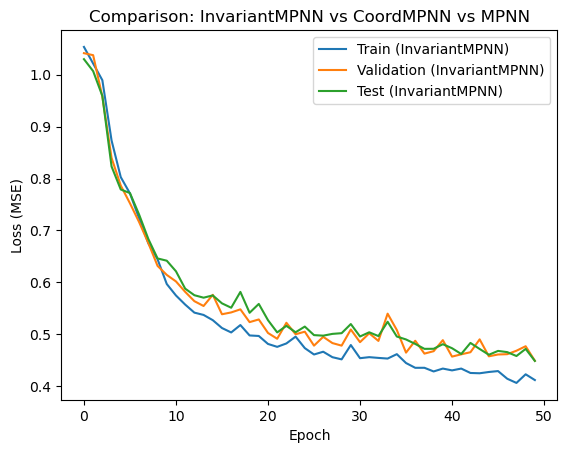

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_inv = InvariantMPNNModel(node_dim=11, edge_dim=4).to(device)  # Adjust dims as needed
optimizer_inv = torch.optim.Adam(model_inv.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

def run_epoch_inv(loader, train=True):
    model_inv.train() if train else model_inv.eval()
    losses = []
    with torch.set_grad_enabled(train):
        for batch in loader:
            batch = batch.to(device)
            optimizer_inv.zero_grad()
            out = model_inv(batch.x, batch.pos, batch.edge_index, batch.edge_attr, batch.batch)
            y = batch.y[:,0]  # Target: normalized dipole moment
            loss = criterion(out.squeeze(), y)
            if train:
                loss.backward()
                optimizer_inv.step()
            losses.append(loss.item())
    return sum(losses) / len(losses)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

epochs = 50
losses_inv_train, losses_inv_val, losses_inv_test = [], [], []

for epoch in range(epochs):
    train_loss_inv = run_epoch_inv(train_loader, train=True)
    val_loss_inv = run_epoch_inv(val_loader, train=False)
    test_loss_inv = run_epoch_inv(test_loader, train=False)
    losses_inv_train.append(train_loss_inv)
    losses_inv_val.append(val_loss_inv)
    losses_inv_test.append(test_loss_inv)
    print(f"Epoch {epoch+1:02d}: train_inv {train_loss_inv:.4f} | val_inv {val_loss_inv:.4f} | test_inv {test_loss_inv:.4f}")

# Plot and compare with previous models (assumed to be train_losses, val_losses, test_losses for MPNNModel,
# and losses_3d_train, losses_3d_val, losses_3d_test for CoordMPNNModel)

plt.plot(losses_inv_train, label='Train (InvariantMPNN)')
plt.plot(losses_inv_val, label='Validation (InvariantMPNN)')
plt.plot(losses_inv_test, label='Test (InvariantMPNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Comparison: InvariantMPNN vs CoordMPNN vs MPNN')
plt.legend()
plt.show()

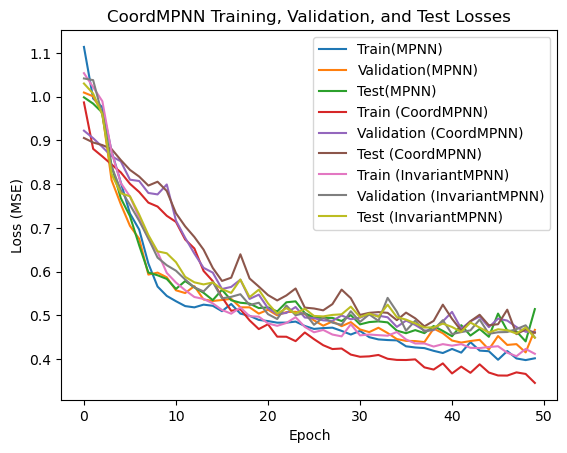

In [13]:
# Plot losses
plt.plot(train_losses, label='Train(MPNN)')
plt.plot(val_losses, label='Validation(MPNN)')
plt.plot(test_losses, label='Test(MPNN)')
plt.plot(train_losses_3d, label='Train (CoordMPNN)')
plt.plot(val_losses_3d, label='Validation (CoordMPNN)')
plt.plot(test_losses_3d, label='Test (CoordMPNN)')
plt.plot(losses_inv_train, label='Train (InvariantMPNN)')
plt.plot(losses_inv_val, label='Validation (InvariantMPNN)')
plt.plot(losses_inv_test, label='Test (InvariantMPNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('CoordMPNN Training, Validation, and Test Losses')
plt.legend()
plt.show()

# Constructing EquivariantMPNNLayer/Model and its comparison with previous models

$$
\begin{equation}
    \mathbf{h}_i^{(l+1)} = \phi \left( \mathbf{h}_i^{(l)}, \sum_{j \in \mathcal{N}(i)} \psi \left( \mathbf{h}_i^{(l)}, \mathbf{h}_j^{(l)}, \mathbf{r}_{ij} \right) \right)
\end{equation}
$$

Clearly, if all coordinates are shifted by $\mathbf{t}$, then $\mathbf{r}_i' = \mathbf{r}_i + \mathbf{t}$. The relative position $\mathbf{r}_{ij}' = (\mathbf{r}_i + \mathbf{t}) - (\mathbf{r}_j + \mathbf{t}) = \mathbf{r}_i - \mathbf{r}_j = \mathbf{r}_{ij}$. Similarly for a rotation matrix $R$, $\mathbf{r}_i' = R\mathbf{r}_i$, then, $\mathbf{r}_{ij}' = R\mathbf{r}_i - R\mathbf{r}_j = R(\mathbf{r}_i - \mathbf{r}_j) = R\mathbf{r}_{ij}$. Thus, the layer is translationally and rotationally equivariant.

In [14]:
class EquivariantMPNNLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim):
        super().__init__(aggr='add')
        self.phi_e = nn.Sequential(
            nn.Linear(2 * node_dim + 1 + edge_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )
        self.phi_h = nn.Sequential(
            nn.Linear(node_dim + node_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, node_dim),
        )
        self.phi_x = nn.Sequential(
            nn.Linear(2 * node_dim + 1 + edge_dim, 1),
            nn.Sigmoid()  # Or identity, depending on application
        )

    def forward(self, x, pos, edge_index, edge_attr):
        row, col = edge_index
        rel_pos = pos[row] - pos[col]  # [num_edges, 3]
        dist = rel_pos.norm(dim=1, keepdim=True)  # [num_edges, 1]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr, rel_pos=rel_pos, dist=dist, pos=pos)

    def message(self, x_i, x_j, edge_attr, rel_pos, dist):
        msg_input = torch.cat([x_i, x_j, dist, edge_attr], dim=-1)
        # Scalar message for node features
        msg_h = self.phi_e(msg_input)
        # Scalar coefficient for position update
        coeff = self.phi_x(msg_input)
        msg_pos = coeff * rel_pos  # [num_edges, 3]
        return msg_h, msg_pos

    def aggregate(self, inputs, index, ptr=None, dim_size=None):
        msg_h, msg_pos = inputs
        aggr_h = torch.zeros(dim_size, msg_h.size(-1), device=msg_h.device).index_add_(0, index, msg_h)
        aggr_pos = torch.zeros(dim_size, msg_pos.size(-1), device=msg_pos.device).index_add_(0, index, msg_pos)
        return aggr_h, aggr_pos

    def update(self, aggr_out, x, pos):
        aggr_h, aggr_pos = aggr_out
        update_input = torch.cat([x, aggr_h], dim=-1)
        x_new = self.phi_h(update_input)
        pos_new = pos + aggr_pos
        return x_new, pos_new

class EquivariantMPNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Linear(node_dim, node_dim)
        self.layers = nn.ModuleList([
            EquivariantMPNNLayer(node_dim, edge_dim) for _ in range(num_layers)
        ])
        self.readout = nn.Sequential(
            nn.Linear(node_dim, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, 3)  # Output a vector property (e.g., dipole moment)
        )

    def forward(self, x, pos, edge_index, edge_attr, batch):
        x = self.embedding(x)
        for layer in self.layers:
            x, pos = layer(x, pos, edge_index, edge_attr)
        # Pool node features to get graph-level vector property
        x_graph = global_add_pool(x, batch)
        return self.readout(x_graph)

# --- Test for equivariance ---
def test_rot_trans_equivariance(model, data, device='cpu'):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        pred_orig = model(data.x, data.pos, data.edge_index, data.edge_attr, data.batch)
        # Translation
        shift = torch.tensor([10.0, -5.0, 3.0], device=data.pos.device)
        pos_translated = data.pos + shift
        pred_translated = model(data.x, pos_translated, data.edge_index, data.edge_attr, data.batch)
        # Rotation
        Q, _ = torch.linalg.qr(torch.randn(3, 3, device=data.pos.device))
        pos_rotated = data.pos @ Q.T
        pred_rotated = model(data.x, pos_rotated, data.edge_index, data.edge_attr, data.batch)
    print("Original prediction:   ", pred_orig.cpu().numpy())
    print("Translated prediction: ", pred_translated.cpu().numpy())
    print("Rotated prediction:    ", pred_rotated.cpu().numpy())
    print("Translation diff (should be zero):", (pred_orig - pred_translated).abs().max().item())
    print("Rotation diff (should match):      ", (pred_orig @ Q - pred_rotated).abs().max().item())

model = EquivariantMPNNModel(node_dim=11, edge_dim=4).to(device)
data_example = test_set[1]
test_rot_trans_invariance(model, data_example, device)

Original prediction:    [[ 0.66841954  0.7195362  -1.4044645 ]]
Translated prediction:  [[ 0.6684197  0.7195362 -1.4044645]]
Rotated prediction:     [[ 0.66841966  0.7195362  -1.4044644 ]]
Translation difference: 1.7881393432617188e-07
Rotation difference:    1.1920928955078125e-07


Epoch 01: train_equiv 0.4182 | val_equiv 0.4565 | test_equiv 0.4609
Epoch 02: train_equiv 0.4093 | val_equiv 0.4461 | test_equiv 0.4530
Epoch 03: train_equiv 0.4085 | val_equiv 0.4828 | test_equiv 0.5091
Epoch 04: train_equiv 0.4063 | val_equiv 0.4358 | test_equiv 0.4457
Epoch 05: train_equiv 0.4000 | val_equiv 0.4921 | test_equiv 0.5139
Epoch 06: train_equiv 0.4182 | val_equiv 0.4628 | test_equiv 0.4752
Epoch 07: train_equiv 0.4092 | val_equiv 0.4537 | test_equiv 0.4533
Epoch 08: train_equiv 0.4022 | val_equiv 0.4380 | test_equiv 0.4321
Epoch 09: train_equiv 0.3911 | val_equiv 0.4495 | test_equiv 0.4713
Epoch 10: train_equiv 0.3936 | val_equiv 0.4395 | test_equiv 0.4290
Epoch 11: train_equiv 0.3991 | val_equiv 0.4482 | test_equiv 0.4400
Epoch 12: train_equiv 0.3961 | val_equiv 0.4381 | test_equiv 0.4398
Epoch 13: train_equiv 0.4010 | val_equiv 0.4451 | test_equiv 0.4566
Epoch 14: train_equiv 0.3906 | val_equiv 0.4383 | test_equiv 0.4253
Epoch 15: train_equiv 0.3979 | val_equiv 0.4652 

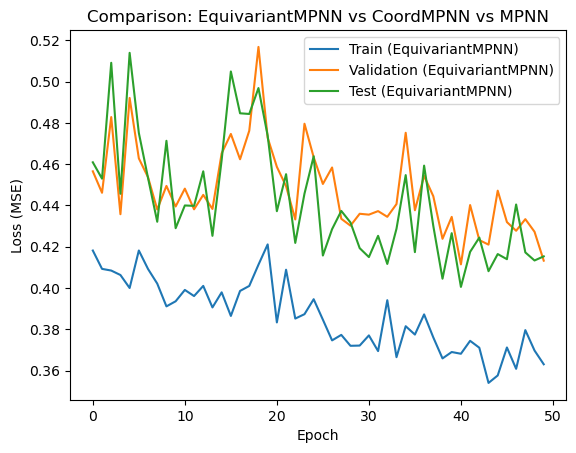

In [15]:
epochs = 50
losses_equiv_train, losses_equiv_val, losses_equiv_test = [], [], []

for epoch in range(epochs):
    train_loss_equiv = run_epoch_inv(train_loader, train=True)  # You may need to adapt run_epoch for vector targets
    val_loss_equiv = run_epoch_inv(val_loader, train=False)
    test_loss_equiv = run_epoch_inv(test_loader, train=False)
    losses_equiv_train.append(train_loss_equiv)
    losses_equiv_val.append(val_loss_equiv)
    losses_equiv_test.append(test_loss_equiv)
    print(f"Epoch {epoch+1:02d}: train_equiv {train_loss_equiv:.4f} | val_equiv {val_loss_equiv:.4f} | test_equiv {test_loss_equiv:.4f}")

# Plot and compare with previous models
plt.plot(losses_equiv_train, label='Train (EquivariantMPNN)')
plt.plot(losses_equiv_val, label='Validation (EquivariantMPNN)')
plt.plot(losses_equiv_test, label='Test (EquivariantMPNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Comparison: EquivariantMPNN vs CoordMPNN vs MPNN')
plt.legend()
plt.show()

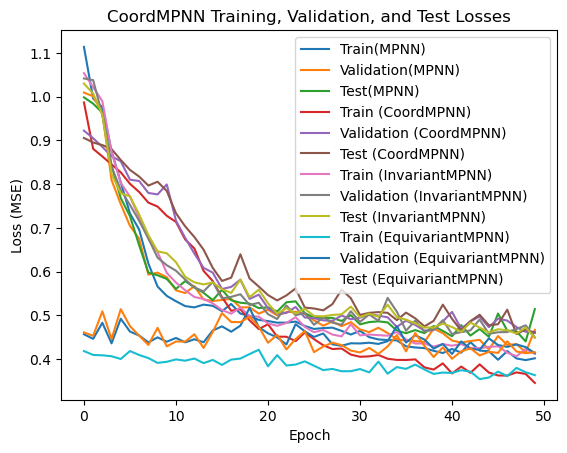

In [16]:
# Plot losses
plt.plot(train_losses, label='Train(MPNN)')
plt.plot(val_losses, label='Validation(MPNN)')
plt.plot(test_losses, label='Test(MPNN)')
plt.plot(train_losses_3d, label='Train (CoordMPNN)')
plt.plot(val_losses_3d, label='Validation (CoordMPNN)')
plt.plot(test_losses_3d, label='Test (CoordMPNN)')
plt.plot(losses_inv_train, label='Train (InvariantMPNN)')
plt.plot(losses_inv_val, label='Validation (InvariantMPNN)')
plt.plot(losses_inv_test, label='Test (InvariantMPNN)')
plt.plot(losses_equiv_train, label='Train (EquivariantMPNN)')
plt.plot(losses_equiv_val, label='Validation (EquivariantMPNN)')
plt.plot(losses_equiv_test, label='Test (EquivariantMPNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('CoordMPNN Training, Validation, and Test Losses')
plt.legend()
plt.show()

From the above analysis, it is very clear that the losses (training/validation/testing) are the least for the equivariant MPNN.